In [1]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"

In [2]:
# Importando as diversas bibliotecas necessárias para o funcionamento do modelo
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import os
import warnings
from torchvision.datasets import Food101
from PIL import Image
import numpy as np
from torchvision import transforms
torch.cuda.empty_cache() 

# Selecionando uma GPU, caso esteja disponível
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


In [3]:
food101set = torchvision.datasets.Food101('./data', download=False)

In [4]:
batch_size = 32
img_size = 64
transformer = torchvision.transforms.Compose([
    torchvision.transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),  # Randomly flip (data augmentation)
    transforms.ToTensor(),  # Converte para tensor (0, 1)
    transforms.Normalize([0.5], [0.5]),  # Mapear para (-1, 1)
])
food101set.transform = transformer

In [5]:
train_dataloader = torch.utils.data.DataLoader(
    food101set, batch_size=batch_size, shuffle=True
)

In [6]:
from diffusers import UNet2DModel

# Criando o modelo
model = UNet2DModel(
    sample_size=img_size,  # resolução da imagem
    in_channels=3,  # o número de canais de entrada (3 por ser RGB)
    out_channels=3,  # o número de canais de saída
    layers_per_block=2,  # quantas camadas de ResNet serão utilziada em cada bloco da UNet
    block_out_channels=(64, 128, 128, 256),  # quanto mais canais, mais parâmetros
    down_block_types=(
        "DownBlock2D",  # bloco de downsampling da ResNet
        "DownBlock2D",
        "AttnDownBlock2D",  # bloco de downsampling da ResNet com self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # bloco de upsampling da ResNet com self-attention
        "UpBlock2D",
        "UpBlock2D",  # bloco de upsampling da ResNet
    ),
)
model.to(device);

In [7]:
from tqdm import tqdm
from diffusers import DDPMScheduler

In [8]:
import gc
gc.collect()


12

In [9]:
# Setando nosso scheduler de ruído
noise_scheduler = DDPMScheduler(
    num_train_timesteps=1000, beta_schedule="squaredcos_cap_v2"
)

# Criando o loop de treinamento
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []
num_epochs = 15

for epoch in tqdm(range(num_epochs), desc = 'Training'):
    for step, batch in enumerate(train_dataloader):
        clean_images = batch[0].to(device)
        # Ruído a ser inserido nas imagens
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Selecionando um timesteps aleatório para cada imagem
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Adicionando ruído às imagens limpas de acordo com o valor do ruído em cada timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Fazendo a predição do modelo
        noise_pred = model(noisy_images, timesteps, return_dict=False)[0]

        # Calculando a função de custo
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Atualizando os parâmetros (pesos) do modelo com o otimizador
        optimizer.step()
        optimizer.zero_grad()

    # Printando o processo a cada 5 épocas
    if (epoch + 1) % 5 == 0:
        loss_last_epoch = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
        print(f"Epoch:{epoch+1}, loss: {loss_last_epoch}")

Training:   0%|                                          | 0/15 [00:00<?, ?it/s]/home/rafael/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:134: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)
Training:  33%|█████████▎                  | 5/15 [2:01:18<4:02:05, 1452.58s/it]

Epoch:5, loss: 0.05234462515422697


Training:  67%|██████████████████         | 10/15 [4:02:07<2:00:47, 1449.43s/it]

Epoch:10, loss: 0.05045292750347053


Training: 100%|█████████████████████████████| 15/15 [6:03:06<00:00, 1452.41s/it]

Epoch:15, loss: 0.04889219097959859


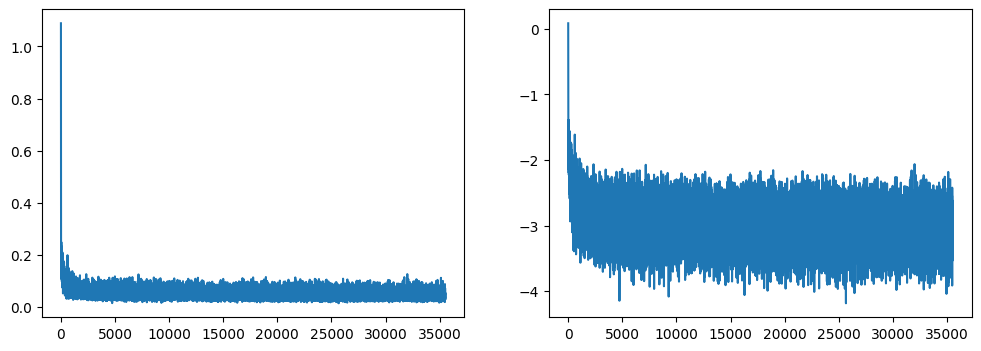

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(losses)
axs[1].plot(np.log(losses))
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

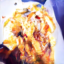

In [13]:
from diffusers import DDPMPipeline

image_pipe = DDPMPipeline(unet=model, scheduler=noise_scheduler)
pipeline_output = image_pipe()
pipeline_output.images[0]